# Likelihood scan for Lya parameterization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our modules
import camb_cosmo
import CAMB_model
import lya_theory
import likelihood
import data_MPGADGET
import gp_emulator
import p1d_arxiv
import iminuit_minimizer
import grid_scanner
import fit_linP

Setup mock data, from one of simulations in the suite

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label=30
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

will drop sim number 30 from emulator


In [3]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max=4.0
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                skewers_label=skewers_label,
                                sim_label=test_sim_label,
                                zmax=z_max)

read cosmology from GenIC /Users/font/Projects/LyaCosmoParams//p1d_emulator/sim_suites/Australia20/sim_pair_30/sim_plus/paramfile.genic
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 2.0061E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00


Setup archive of P1D measurements from simulations to train the emulator

In [4]:
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc)
emu.load_default()

 /Library/Python/3.7/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Setup LyaTheory, explicit in case we don't use any cosmo param and likelihood gets confused

In [6]:
# specify whether to use true cosmology in simulation as fiducial (easier test)
use_sim_fid=False
if use_sim_fid:
    sim_cosmo=data.mock_sim.sim_cosmo
    print('use true cosmo as fiducial')
    camb_cosmo.print_info(sim_cosmo)
    theory=lya_theory.LyaTheory(zs=data.z,emulator=emu,cosmo_fid=sim_cosmo)
else:
    theory=lya_theory.LyaTheory(zs=data.z,emulator=emu)
    print('use default cosmo as fiducial')
    camb_cosmo.print_info(theory.cosmo.cosmo_fid)

use default cosmo as fiducial
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


Setup likelihood and free parameters

In [7]:
# Likelihood parameters (option to fix cosmology for testing)
fix_cosmo=False
if fix_cosmo:
    assert use_sim_fid,'do you want to fix the cosmology when not using the right one?'
    like_params=["ln_tau_0","ln_sigT_kms_0","ln_gamma_0"]
    like_param_limits=[[-0.2, 0.2],[-0.5, 0.5],[-0.2, 0.2]]
else:
    like_params=["Delta2_star","n_star","ln_tau_0","ln_sigT_kms_0","ln_gamma_0"]
    like_param_limits=[[0.24, 0.47], [-2.352, -2.25], [-0.2, 0.2],
            [-0.5, 0.5], [-0.2, 0.2]]

In [8]:
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,
                            prior_Gauss_rms=0.5)

In [9]:
## Evaluate log_prob at random point in parameter space
theta=np.ones(len(like_params))*0.5 ## Just pick the middle of likelihood space
print('starting point')
for par in like.parameters_from_sampling_point(theta):
    print(par.info_str())
chi2_test=like.get_chi2(theta)
print('starting chi2',chi2_test)

starting point
Delta2_star = 0.355
n_star = -2.301
ln_tau_0 = 0.0
ln_sigT_kms_0 = 0.0
ln_gamma_0 = 0.0
starting chi2 2.7599877339233374


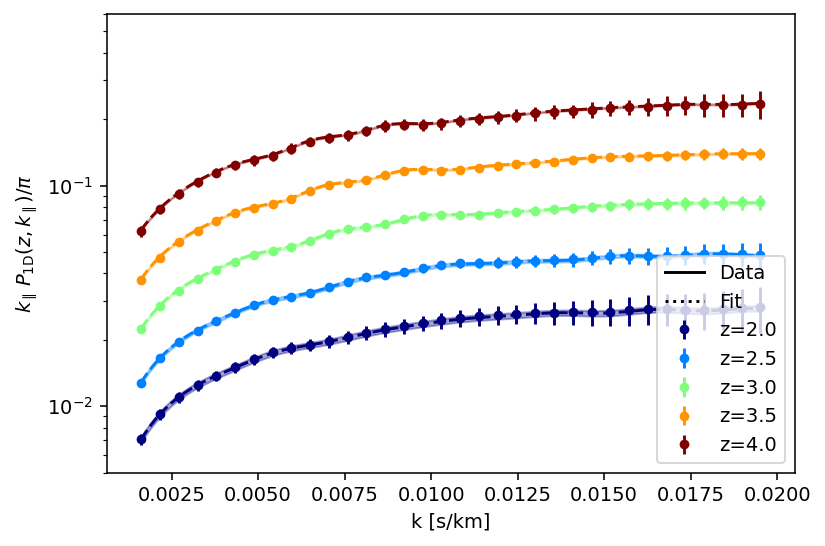

In [10]:
like.plot_p1d(plot_every_iz=2)

### Setup our own minimizer

In [11]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

will run migrad
------------------------------------------------------------------
| FCN = 34.44                   |     Ncalls=159 (159 total)     |
| EDM = 3.31e-07 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
will compute Hessian matrix
best-fit values = [0.40113485 0.47700151 0.54009161 0.45902656 0.58193469]


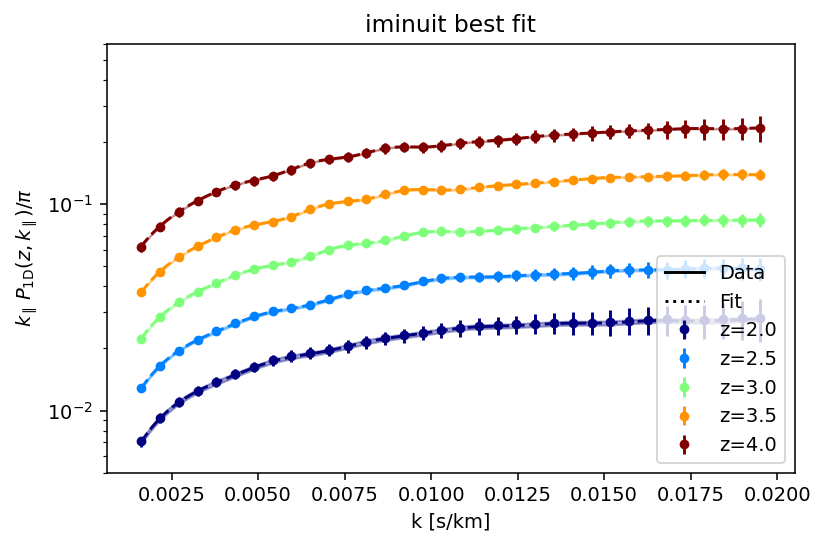

In [12]:
minimizer.minimize()
minimizer.plot_best_fit(plot_every_iz=2)

In [13]:
best_fit=minimizer.minimizer.np_values()
print('best-fit values',best_fit)
print('best-fit log_like',minimizer.like.get_log_like(best_fit))
print('best-fit minus_log_prob',minimizer.like.minus_log_prob(best_fit))
print('best-fit log_prob',minimizer.like.log_prob(best_fit))
print('best-fit log_prior',minimizer.like.get_log_prior(best_fit))
print('best-fit log_like (with cov)',minimizer.like.get_log_like(best_fit,ignore_log_det_cov=False))

best-fit values [0.40113485 0.47700151 0.54009161 0.45902656 0.58193469]
best-fit log_like -34.386353447643906
best-fit minus_log_prob 34.438991678121575
best-fit log_prob -34.438991678121575
best-fit log_prior -0.05263823047766904
best-fit log_like (with cov) -34.386353447643906


### Compute true values for the linear power parameters

In [14]:
sim_cosmo=data.mock_sim.sim_cosmo
z_star=like.theory.cosmo.z_star
kp_kms=like.theory.cosmo.kp_kms
true_linP=fit_linP.parameterize_cosmology_kms(cosmo=data.mock_sim.sim_cosmo,z_star=z_star,kp_kms=kp_kms)
print('true linP parameters',true_linP)

true linP parameters {'f_star': 0.9813909211842693, 'g_star': 0.9677508863420937, 'linP_kms': poly1d([-0.10814533, -2.29694694, 16.05446004]), 'Delta2_star': 0.3465462402543562, 'n_star': -2.29694694017462, 'alpha_star': -0.2162906520970914}


### Setup a 1D chi2 scan

In [15]:
N=11
true_n_star=true_linP['n_star']
grid={'name':'n_star','minval':true_n_star-0.03,'maxval':true_n_star+0.03,'nval':N}
scan1D=grid_scanner.Scan1D(like,param_grid=grid)
# compute actual scan (might be slow)
_=scan1D.get_grid_scan()

will compute grid scan
will run migrad
------------------------------------------------------------------
| FCN = 34.44                   |     Ncalls=159 (159 total)     |
| EDM = 3.31e-07 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
global chi2 = 0.7935532540474426 ; best-fit = [0.40113485 0.47700151 0.54009161 0.45902656 0.58193469]
1 n_star -2.32694694017462 in cube 0.24561823358215693

------------------------------------------------------------------
| FCN = 43.49                   |      Ncalls=81 (81 total)      |
| EDM = 4.12e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
1 n_star -2.2669469401746203 in cube 0.8338535276998009
will run migrad
------------------------------------------------------------------
| FCN = 45.1                    |     Ncalls=105 (105 tot

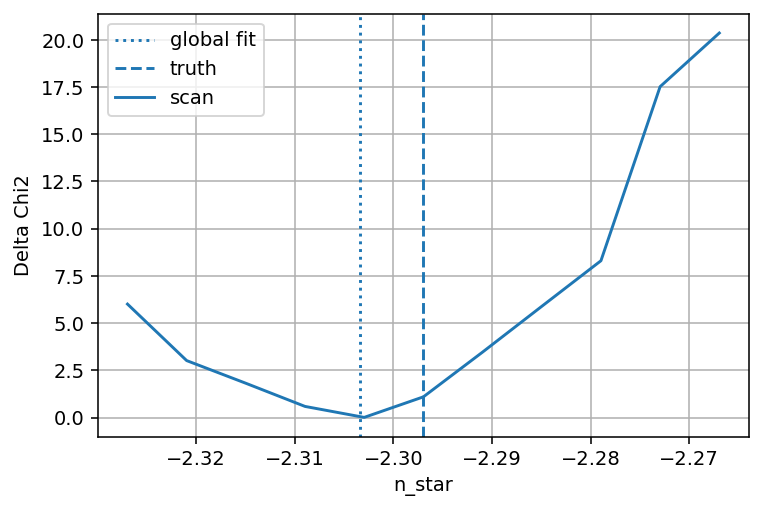

In [16]:
scan1D.plot_grid_scan(true_value=true_n_star)

In [17]:
N=11
true_Delta2_star=true_linP['Delta2_star']
grid={'name':'Delta2_star','minval':true_Delta2_star-0.1,'maxval':true_Delta2_star+0.1,'nval':N}
scan1D=grid_scanner.Scan1D(like,param_grid=grid)
# compute actual scan (might be slow)
scan1D.get_grid_scan()

will compute grid scan
will run migrad
------------------------------------------------------------------
| FCN = 34.44                   |     Ncalls=159 (159 total)     |
| EDM = 3.31e-07 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
global chi2 = 0.7935532540474426 ; best-fit = [0.40113485 0.47700151 0.54009161 0.45902656 0.58193469]
0 Delta2_star 0.2465462402543562 in cube 0.02846191414

 /Library/Python/3.7/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


------------------------------------------------------------------
| FCN = 48.71                   |     Ncalls=208 (208 total)     |
| EDM = 7.54e-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
0 Delta2_star 0.2665462402543562 in cube 0.11541843588850523
will run migrad
------------------------------------------------------------------
| FCN = 41.61                   |     Ncalls=187 (18

------------------------------------------------------------------
| FCN = 47.78                   |     Ncalls=137 (137 total)     |
| EDM = 6.76e-07 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


(array([0.24654624, 0.26654624, 0.28654624, 0.30654624, 0.32654624,
        0.34654624, 0.36654624, 0.38654624, 0.40654624, 0.42654624,
        0.44654624]),
 array([-47.92440209, -41.06780768, -37.03709155, -35.45655717,
        -34.44144763, -34.90000443, -36.66015072, -38.69601606,
        -40.97142644, -43.78531945, -47.072391  ]))

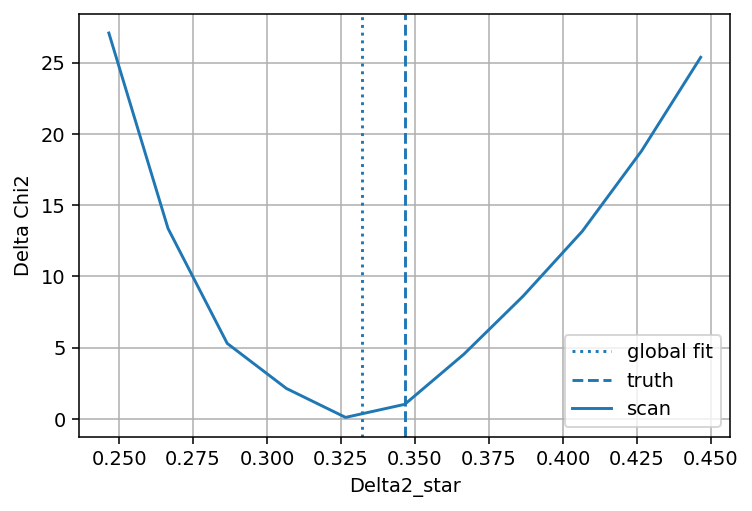

In [18]:
scan1D.plot_grid_scan(true_value=true_Delta2_star)

 /Library/Python/3.7/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


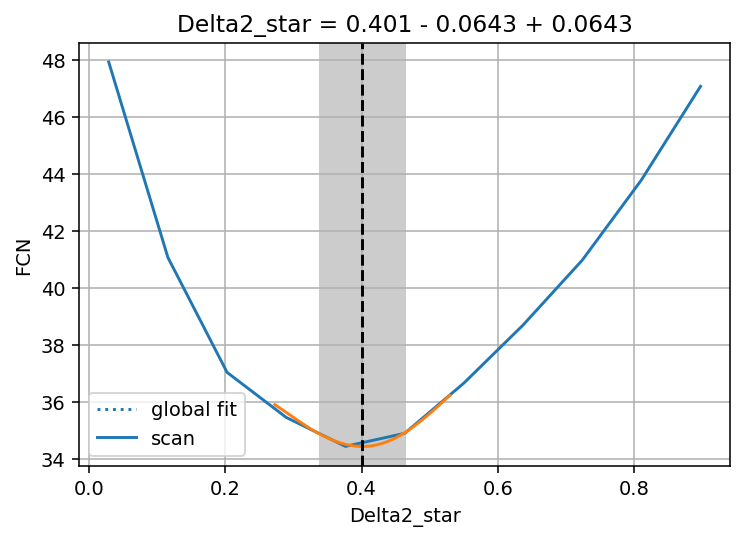

In [19]:
# compare with function from iminuit (cube values)
scan1D.plot_grid_scan(cube_values=True,yaxis='MinusLogLike')
minimizer.minimizer.draw_mnprofile(vname='Delta2_star',bins=30);

### Setup a 2D chi2 scan

In [ ]:
N1=11
N2=11
grid_1={'name':'Delta2_star','minval':true_Delta2_star-0.1,'maxval':true_Delta2_star+0.1,'nval':N1}
grid_2={'name':'n_star','minval':true_n_star-0.03,'maxval':true_n_star+0.03,'nval':N2}
scan2D=grid_scanner.Scan2D(like,param_grid_1=grid_1,param_grid_2=grid_2)
# compute actual scan (might be slow)
_=scan2D.get_grid_scan()

will compute grid scan
will run migrad
------------------------------------------------------------------
| FCN = 34.44                   |     Ncalls=159 (159 total)     |
| EDM = 3.31e-07 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
global chi2 = 0.7935532540474426 ; best-fit = [0.40113485 0.47700151 0.54009161 0.45902656 0.58193469]
0 Delta2_star 0.2465462402543562 in cube 0.02846191414

 /Library/Python/3.7/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


------------------------------------------------------------------
| FCN = 51.36                   |     Ncalls=113 (113 total)     |
| EDM = 1.94e-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
0 Delta2_star 0.3865462402543562 in cube 0.6371575663232879
1 n_star -2.32694694017462 in cube 0.24561823358215693
will run migrad
-----------------------------------------------------------------

------------------------------------------------------------------
| FCN = 37.67                   |      Ncalls=69 (69 total)      |
| EDM = 2.86e-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
0 Delta2_star 0.3465462402543562 in cube 0.46324452284502704
1 n_star -2.32094694017462 in cube 0.3044417629939196
will run migrad
-----------------------------------------------------------------

------------------------------------------------------------------
| FCN = 38.4                    |      Ncalls=88 (88 total)      |
| EDM = 7.06e-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
0 Delta2_star 0.3065462402543562 in cube 0.289331479366766
1 n_star -2.31494694017462 in cube 0.3632652924056866
will run migrad
------------------------------------------------------------------


------------------------------------------------------------------
| FCN = 56.34                   |      Ncalls=99 (99 total)      |
| EDM = 4.7e-05 (Goal: 0.0001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
0 Delta2_star 0.2665462402543562 in cube 0.11541843588850523
1 n_star -2.30894694017462 in cube 0.4220888218174493
will run migrad
-----------------------------------------------------------------

In [ ]:
scan2D.plot_grid_scan(true_values=[true_Delta2_star,true_n_star])

In [ ]:
# plot 1,2,3 sigma instead of 68%,95%,99.7% 
scan2D.plot_grid_scan(true_values=[true_Delta2_star,true_n_star],levels=[1,4,9])

In [ ]:
# compare to iminuit, using cube values, and for 1D sigmas
scan2D.plot_grid_scan(true_values=[true_Delta2_star,true_n_star],cube_values=True,zaxis='DeltaChi2',levels=[1,4,9])
# this will take a while, it computes several minimizations
minimizer.minimizer.draw_mncontour('Delta2_star','n_star',numpoints=20)

In [ ]:
minimizer.plot_ellipses('Delta2_star','n_star',cube_values=False)
plt.axvline(x=true_Delta2_star,ls='--',color='gray',label='truth')
plt.axhline(y=true_n_star,ls='--',color='gray')
plt.legend()

In [ ]:
val,err=minimizer.best_fit_value('Delta2_star',return_hesse=True)

In [ ]:
err/val